In [1]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.9 MB/s eta 0:00:00


In [2]:
from torchgeometry.losses import one_hot
import multiprocessing
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.transforms import v2, PILToTensor, ToPILImage, InterpolationMode, Compose, Resize
from collections import OrderedDict
import wandb

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-690cafc0-678b-808b-f1b1-0eb1dea1fbb0)
GPU 1: Tesla T4 (UUID: GPU-4d538b34-3b99-3b8d-79e2-b31184a1a1eb)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Parameters

In [5]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 31

# Hyperparameters for training 
learning_rate = 1e-04
batch_size = 8
display_step = 50

# Model path
checkpoint_path = '../working/unet_model.pth'
pretrained_path = "../input/unet-checkpoint/unet_model.pth"

# Dataloader

In [6]:
transform = Compose([Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

In [7]:
# augmented_transform = v2.Compose([
#     v2.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
#     v2.ColorJitter(brightness=.5, hue=.3),
#     v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.5),
#     v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
#     PILToTensor()
# ])

In [8]:
images_path = "../input/bkai-igh-neopolyp/train/train/"
masks_path =  "../input/bkai-igh-neopolyp/train_gt/train_gt/"

In [9]:
from albumentations import Compose, CoarseDropout, RandomBrightnessContrast, HorizontalFlip, VerticalFlip, RandomGamma, RGBShift, RandomCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
augmented_transform = Compose([
    RandomCrop(height=256, width=256, p=0.2),
    CoarseDropout(p=0.2, max_height=35, max_width=35),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5)
])

In [11]:
class AugDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform=None, augmented_transform=None):
        super(AugDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.augmented_transform = augmented_transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        # Augmentation
        if self.augmented_transform:
            augmented = self.augmented_transform(image=np.array(data), mask=np.array(label))
            data = Image.fromarray(augmented['image'])
            label = Image.fromarray(augmented['mask'])
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label > 0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [12]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label>0.65, 1.0, 0.0)
        
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [13]:
train_size = 0.9
valid_size = 0.1

In [14]:
dataset_not_aug = UNetDataClass(images_path = images_path, masks_path = masks_path, transform = transform)
train_not_aug_set, valid_not_aug_set = random_split(dataset_not_aug, 
                                    [int(train_size * len(dataset_not_aug)) , 
                                     int(valid_size * len(dataset_not_aug))])

dataset_aug = AugDataClass(images_path = images_path, masks_path = masks_path, transform = transform, augmented_transform = augmented_transform)
train_aug_set, valid_aug_set = random_split(dataset_aug, 
                                    [int(train_size * len(dataset_aug)) , 
                                     int(valid_size * len(dataset_aug))])

train_set = ConcatDataset([train_not_aug_set, train_aug_set])
valid_set = ConcatDataset([valid_not_aug_set, valid_aug_set])

print(len(train_set))

1800


In [15]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.Pool()._processes)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=multiprocessing.Pool()._processes)

# Model

In [16]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.2 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Loss function

In [17]:
from functools import partial
from torch.nn.modules.loss import _Loss
from typing import Optional

def focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    alpha: Optional[float] = 0.25,
    reduction: str = "mean",
    normalized: bool = False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    
    target = target.type(output.type())

    logpt = F.binary_cross_entropy_with_logits(output, target, reduction="none")
    pt = torch.exp(-logpt)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * logpt

    if alpha is not None:
        loss *= alpha * target + (1 - alpha) * (1 - target)

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss /= norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss

class FocalLoss(_Loss):
    def __init__(
        self,
        alpha: Optional[float] = None,
        gamma: Optional[float] = 2.0,
        ignore_index: Optional[int] = None,
        reduction: Optional[str] = "mean",
        normalized: bool = False,
        reduced_threshold: Optional[float] = None,
    ):
        super().__init__()

        self.ignore_index = ignore_index
        self.focal_loss_fn = partial(
            focal_loss_with_logits,
            alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        num_classes = y_pred.size(1)
        loss = 0

        if self.ignore_index is not None:
            not_ignored = y_true != self.ignore_index

        for cls in range(num_classes):
            cls_y_true = (y_true == cls).long()
            cls_y_pred = y_pred[:, cls, ...]

            if self.ignore_index is not None:
                cls_y_true = cls_y_true[not_ignored]
                cls_y_pred = cls_y_pred[not_ignored]

            loss += self.focal_loss_fn(cls_y_pred, cls_y_true)

        return loss

# Training

**Initialize weights**

In [18]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

**Train model**

In [19]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [20]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

In [21]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=3,
)

model = nn.DataParallel(model)
model.to(device)
# model = nn.DataParallel(model)
# checkpoint = torch.load(pretrained_path)

# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [22]:
loss_function = FocalLoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [23]:
save_model(model, optimizer, checkpoint_path)

In [24]:
wandb.login(key='02c8923278a3dc82932fafb9959cd6d7587dacc7')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [25]:
# from tensorflow.compat.v1 import InteractiveSession
# import tensorflow as tf
# tf.keras.backend.clear_session()
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [26]:
# torch.cuda.empty_cache()

In [27]:
wandb.init(
    project = "NeoPolypSegment"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

wandb: Currently logged in as: mint21. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231117_150106-mgy8klsv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sunny-water-208
wandb: ⭐️ View project at https://wandb.ai/mint21/NeoPolypSegment
wandb: 🚀 View run at https://wandb.ai/mint21/NeoPolypSegment/runs/mgy8klsv


Start epoch #1, learning rate for this epoch: [0.0001]
Train Epoch: 1 [400/1800 (22.22222222222222%)]	Loss: 0.4855
Train Epoch: 1 [800/1800 (44.44444444444444%)]	Loss: 0.2465
Train Epoch: 1 [1200/1800 (66.66666666666667%)]	Loss: 0.1709
Train Epoch: 1 [1600/1800 (88.88888888888889%)]	Loss: 0.1265
Done epoch #1, time for this epoch: 57.42616033554077s
Start epoch #2, learning rate for this epoch: [0.0001]
Train Epoch: 2 [400/1800 (22.22222222222222%)]	Loss: 0.1014
Train Epoch: 2 [800/1800 (44.44444444444444%)]	Loss: 0.0870
Train Epoch: 2 [1200/1800 (66.66666666666667%)]	Loss: 0.1783
Train Epoch: 2 [1600/1800 (88.88888888888889%)]	Loss: 0.1062
Done epoch #2, time for this epoch: 44.55587410926819s
Start epoch #3, learning rate for this epoch: [0.0001]
Train Epoch: 3 [400/1800 (22.22222222222222%)]	Loss: 0.0961
Train Epoch: 3 [800/1800 (44.44444444444444%)]	Loss: 0.0502
Train Epoch: 3 [1200/1800 (66.66666666666667%)]	Loss: 0.0562
Train Epoch: 3 [1600/1800 (88.88888888888889%)]	Loss: 0.0990

In [28]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Plot the learning cure

In [29]:
# load_model(model, checkpoint)
torch.cuda.empty_cache()

In [30]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

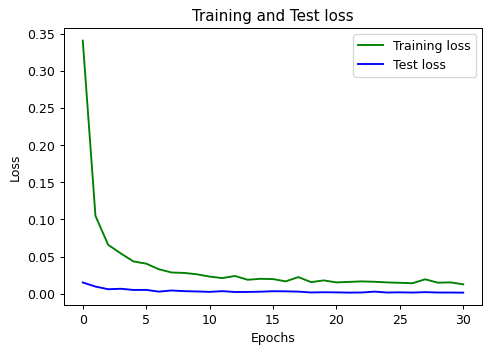

In [31]:
# Plot Training and Test loss
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Infer**

In [32]:
# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

In [33]:
# optimizer.load_state_dict(checkpoint['optimizer'])

In [34]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

**Visualize results**

In [35]:
for i, (data, label) in enumerate(train_dataloader):
    img = data
    mask = label
    break

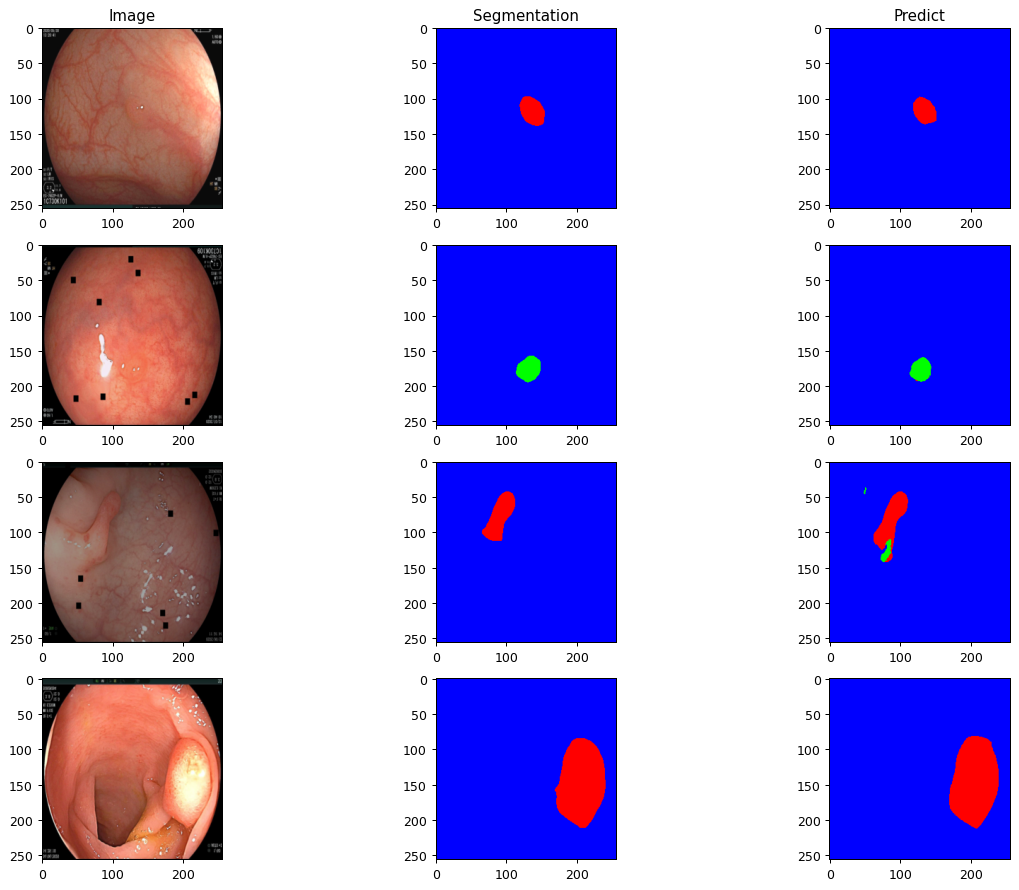

In [36]:
fig, arr = plt.subplots(4, 3, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(4):
    arr[i][0].imshow(img[i+4].permute(1, 2, 0));
    
    arr[i][1].imshow(F.one_hot(mask[i+4]).float())
    
    arr[i][2].imshow(F.one_hot(torch.argmax(predict[i+4], 0).cpu()).float())

**Create submission**

In [37]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [38]:
path = '../input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)

In [39]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

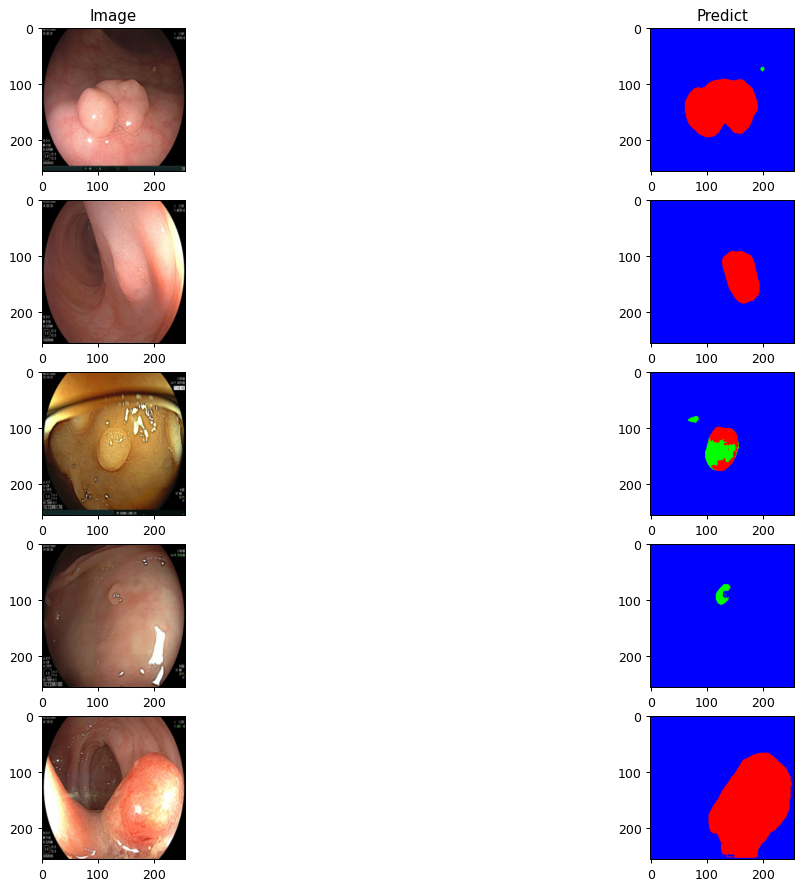

In [40]:
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [41]:
model.eval()
if not os.path.isdir("../working/predicted_masks"):
    os.mkdir("../working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("../working/predicted_masks/", filename))

In [42]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '../working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

../working/predicted_masks/e3c84417fda8019410b1fcf0625f608b.png
../working/predicted_masks/6d3694abb47953b0e4909384b57bb6a0.png
../working/predicted_masks/6231002ec4a1fe748f3085f1ce88cbdf.png
../working/predicted_masks/626650908b1cb932a767bf5487ced51b.png
../working/predicted_masks/7af2ed9fbb63b28163a745959c039830.png
../working/predicted_masks/ea42b4eebc9e5a87e443434ac60af150.png
../working/predicted_masks/fb905b78a91391adc0bb223c4eaf3372.png
../working/predicted_masks/e1e0ae936de314f2d95e6c487ffa651b.png
../working/predicted_masks/318ecf467d7ad048df39beb176363408.png
../working/predicted_masks/cf6644589e532a9ee954f81faedbce39.png
../working/predicted_masks/66e057db382b8564872a27301a654864.png
../working/predicted_masks/dc0bb223c4eaf3372eae567c94ea04c6.png
../working/predicted_masks/26679bff55177a34fc01019eec999fd8.png
../working/predicted_masks/67d4dcf9596154efb7cef748d9cbd617.png
../working/predicted_masks/df8e26031fbb5e52c41545ba55aadaa7.png
../working/predicted_masks/d6240619ebebe